In [61]:
using Pkg
Pkg.activate("psyc261")
using Distributions
using ProgressMeter
using Gen, Plots
using Parameters
using PyCall
using PyPlot
using JLD2

ENV["PYTHON"] = "/Users/dongyu/opt/anaconda3/envs/modeling/bin/python"
println(PyCall.python)

  Activating project at `~/Documents/Github/final_project/lab-05/psyc261`


/Users/dongyu/opt/anaconda3/envs/modeling/bin/python


In [65]:
np = pyimport("numpy")
mi = pyimport("mitsuba")
pickle = pyimport("pickle")

PyObject <module 'pickle' from '/Users/dongyu/opt/anaconda3/envs/modeling/lib/python3.10/pickle.py'>

In [100]:
py"""
import numpy as np
import mitsuba as mi
mi.set_variant("scalar_rgb")
from mitsuba import ScalarTransform4f as T
def initialize_scene(wall_color, floor_color, object_color, object_type, object_scale):

    d = {
        "type": "scene",
        "integrator": {
            'type': 'path',
            'max_depth': 6,
        },
        
        'sensor': {
            'type': 'perspective',
            'fov_axis': 'smaller',
            'near_clip': 0.001,
            'far_clip': 100.0,
            'focus_distance': 1000,
            'fov': 39.3077,
            'to_world': T.look_at(
                origin=[0, 0, 4],
                target=[0, 0, 0],
                up=[0, 1, 0]
            ),
            'sampler': {
                'type': 'independent',
                'sample_count': 16
            },
            'film': {
                'type': 'hdrfilm',
                'width' : 64,
                'height': 64,
                'rfilter': {
                    'type': 'tent',
                },
                'pixel_format': 'rgb',
                'component_format': 'float32',
            }
        },

        # -------------------- BSDFs --------------------

        'white': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.885809, 0.698859, 0.666422],
            }
        },

        'green': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.105421, 0.37798, 0.076425],
            }
        },
        'Red': {
            'type': 'diffuse',
            'reflectance': {
                'type': 'rgb',
                'value': [0.570068, 0.0430135, 0.0443706],
            }
        },
        
        # -------------------- Light --------------------
        'light': {
            'type': 'rectangle',
            'to_world': T.translate([0.0, 0.99, 0.01]).rotate([1, 0, 0], 90).scale([0.23, 0.19, 0.19]),
            'bsdf': {
                'type': 'ref',
                'id': 'white'
            },
            'emitter': {
                'type': 'area',
                'radiance': {
                    'type': 'rgb',
                    'value': [18.387, 13.9873, 6.75357],
                }
            }
        },

        'floor': {
            'type': 'obj',
            'filename': 'meshes/cbox_floor.obj',
            'floor-bsdf': {
                'type' : 'ref',
                'id' : floor_color
            }
        },

        'ceiling': {
            'type': 'obj',
            'filename': 'meshes/cbox_ceiling.obj',
            'ceiling-bsdf': {
                'type' : 'ref',
                'id' : wall_color
            }
        },
        
        'rear': {
            'type': 'obj',
            'filename': 'meshes/cbox_back.obj',
            'back-bsdf': {
                'type' : 'ref',
                'id' : wall_color
            }
        },

        'leftwall': {
            'type': 'obj',
            'filename': 'meshes/cbox_greenwall.obj',
            'greenwall-bsdf': {
                'type' : 'ref',
                'id' : wall_color
            }
        },
        'rightwall': {
            'type': 'obj',
            'filename': 'meshes/cbox_redwall.obj',
            'redwall-bsdf': {
                'type' : 'ref',
                'id' : wall_color
            }
        },
        
        'left_object': {
            'type': 'sphere',
            'to_world': T.translate([0, -0.5, 0]).scale(object_scale),
            'leftobject-bsdf': {
                'type' : 'ref',
                'id' : object_color
            }
        },

    }
    return d

"""

In [87]:
wall_colors = ["white", "green", "Red"]
floor_colors = ["white", "green", "Red"]
object_colors = ["white", "green", "Red"]
object_types = ["sphere", "rectangle"]
object_scales = [0.3, 0.5, 0.7]
spp = 512


512

In [101]:
mitsuba_data = []
for (wall_color, floor_color, object_color, object_type, object_scale) in Iterators.product(wall_colors, floor_colors, object_colors, object_types, object_scales)
    scene_d = py"initialize_scene"(wall_color, floor_color, object_color, object_type, object_scale)
    # load the scene using the load_dict function
    scene = mi.load_dict(scene_d)
    # render the scene
    image = mi.render(scene, spp=spp)
    bitmap = mi.Bitmap(image).convert(srgb_gamma=true)
    mu = @pycall np.array(bitmap)::Array{Float32, 3}
    mu = np.clip(mu, 0, 1)
    mu = reshape(mu, (1, 64, 64, 3))
    push!(mitsuba_data, mu)
end
mitsuba_data = np.concatenate(mitsuba_data, axis=0)
;

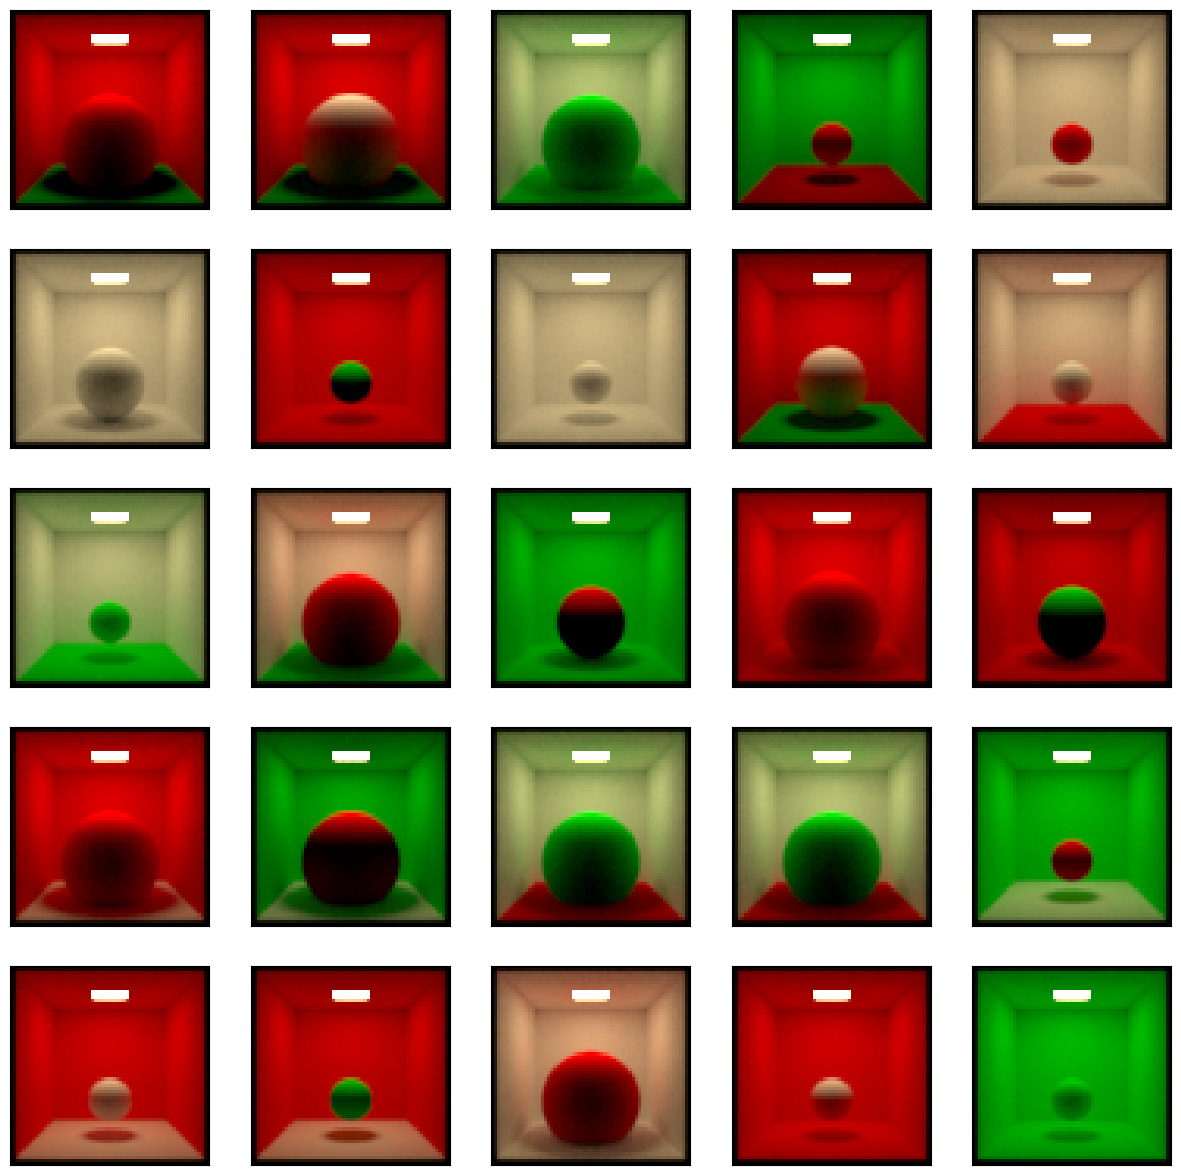

In [98]:
py"""
import numpy as np
import matplotlib.pyplot as plt
def show_images_grid(imgs_, num_images=25):
  imgs_ = imgs_.astype(np.float32)
  ncols = int(np.ceil(num_images**0.5))
  nrows = int(np.ceil(num_images / ncols))
  fig, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
  axes = axes.flatten()
  rand_idxs = np.random.choice(imgs_.shape[0], size=num_images, replace=False)
  for ax_i, ax in enumerate(axes):
    if ax_i < num_images:
      ax.imshow(imgs_[rand_idxs[ax_i]], cmap='Greys_r', interpolation='nearest')
      ax.set_xticks([])
      ax.set_yticks([])
    else:
      ax.axis('off')
  return fig
"""

display(py"show_images_grid"(mitsuba_data))

# Util functions

In [73]:

py"""
import tqdm
import matplotlib.pyplot as plt
from scipy.special import softmax
import tensorflow_datasets as tfds

def mask_image_random(n):
    random_arrays = []
    for i in range(n):
        random_array = np.random.uniform(-1, 1, size=(64, 64, 3))
        random_arrays.append(random_array)
    return random_arrays

def display(array1, array2, seed=None, title='Inputs and outputs of the model', n=10):
    hopfield = False

    dim = array1[0].shape[0]
    # Displays ten random images from each one of the supplied arrays.
    if seed is not None:
        np.random.seed(seed)

    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]

    fig = plt.figure(figsize=(20, 4))
    for i, (image1, image2) in enumerate(zip(images1, images2)):
        ax = plt.subplot(2, n, i + 1)
        if hopfield is True:
            plt.imshow(image1.reshape(dim, dim), cmap='binary', vmin=-1, vmax=1)
        else:
            plt.imshow(image1.reshape(dim, dim, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(2, n, i + 1 + n)
        if hopfield is True:
            plt.imshow(image2.reshape(dim, dim), cmap='binary', vmin=-1, vmax=1)
        else:
            plt.imshow(image2.reshape(dim, dim, 3))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig.suptitle(title)
    plt.show()
    return fig

def preprocess(array):
    # Normalizes the supplied array and reshapes it into the appropriate format.
    array = array.astype("float64") / 255.0
    return array

def prepare_data(dataset, display=False, noise_factor=0.6, labels=False,train=None, test=None):
    # Normalize and reshape the data
    train_data = preprocess(train)
    test_data = preprocess(test)

    # Create a copy of the data with added noise
    noisy_train_data = noise(train_data, noise_factor=noise_factor)
    noisy_test_data = noise(test_data, noise_factor=noise_factor)

    # Display the train data and a version of it with added noise
    if display is True:
        display(train_data, noisy_train_data)

    if labels is False:
        return train_data, test_data, noisy_train_data, noisy_test_data

def plot_history(history, titles=True):
    recon_loss_values = history.history['reconstruction_loss']
    epochs = range(1, len(recon_loss_values) + 1)

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.set_ylabel("Reconstruction error")
    ax.plot(epochs, recon_loss_values, label='Reconstruction Error', color='red')

    if titles is True:
        lines, labels = ax.get_legend_handles_labels()
        plt.title('Reconstruction error over time')

    ax.set_xlabel('Epoch')
    plt.show()
    return fig
    
def noise(array, noise_factor=0.4, seed=None, gaussian=False, replacement_val=0):
    # Replace a fraction noise_factor of pixels with replacement_val or gaussian noise
    if seed is not None:
        np.random.seed(seed)
    shape = array.shape
    array = array.flatten()
    indices = np.random.choice(np.arange(array.size), replace=False,
                               size=int(array.size * noise_factor))
    if gaussian is True:
        array[indices] = np.random.normal(loc=0.5, scale=1.0, size=array[indices].shape)
    else:
        array[indices] = replacement_val
    array = array.reshape(shape)
    return np.clip(array, 0.0, 1.0)

def check_generative_recall(vae, test_data, noise_level=0.1):
    test_data = noise(test_data, noise_factor=noise_level)
    latents = vae.encoder.predict(test_data)
    predictions = vae.decoder.predict(latents[0])
    fig = display(test_data, predictions, title='Inputs and outputs for VAE')
    return fig

"""


In [74]:
py"""
import numpy as np
import tensorflow as tf
class ContinuousHopfield:
    def __init__(self, pat_size, beta=20, do_normalization=True):
        self.size = pat_size  # size of individual pattern
        self.beta = beta
        print(self.beta)
        self.max_norm = np.sqrt(self.size)
        if do_normalization:
            self.softmax = self.softmax_normalized
            self.energy = self.energy_normalized
        else:
            self.softmax = self.softmax_unnormalized
            self.energy = self.energy_unnormalized

        return

    def learn(self, patterns):
        # expects patterns as numpy arrays and stores them col-wise in pattern matrix 
        self.num_pat = len(patterns)
        assert (all(type(x) is np.ndarray for x in patterns)), 'not all input patterns are numpy arrays'
        assert (all(len(x.shape) == 2 for x in patterns)), 'not all input patterns have dimension 2'
        assert (all(1 == x.shape[1] for x in patterns)), 'not all input patterns have shape (-1,1) '
        self.patterns = np.array(patterns).squeeze(axis=-1).T  # save patterns col-wise
        # without squeeze axis would result in problem with one pattern
        # return -1*np.sum(np.exp([(self.patterns[:,ii].T @pattern)/self.max_norm for ii in range(self.patterns.shape[1])]))
        self.M = max(np.linalg.norm(vec) for vec in patterns)  # maximal norm of actually stored patterns
        return

    def retrieve(self, partial_pattern, max_iter=np.inf, thresh=0.5):
        # partial patterns have to be provided with None/0 at empty spots
        if partial_pattern.size != self.size:
            raise ValueError("Input pattern %r does not match state size: %d vs %d"
                             % (partial_pattern, len(partial_pattern), self.size))

        if None in partial_pattern:
            raise NotImplementedError("None elements not supported")

        assert type(partial_pattern) == np.ndarray, 'test pattern was not numpy array'
        assert len(partial_pattern.shape) == 2 and 1 == partial_pattern.shape[
            1], 'test pattern with shape %r is not a col-vector' % (partial_pattern.shape,)

        pat_old = partial_pattern.copy()
        iters = 0

        while iters < max_iter:
            pat_new = self.patterns @ self.softmax(self.beta * self.patterns.T @ pat_old)

            if np.count_nonzero(pat_old != pat_new) <= thresh:  # converged
                break
            else:
                pat_old = pat_new
            iters += 1

        return pat_new

    def softmax_unnormalized(z):
        return softmax(z)  # Scipy's softmax is numerically stable

    def softmax_normalized(self, z):
        return softmax(z / self.max_norm)

    @staticmethod
    def _lse(z, beta):
        return 1 / beta * np.log(np.sum(np.exp(beta * z)))

    def energy_unnormalized(self, pattern):
        return -1 * self._lse(self.patterns.T @ pattern, 1) + 0.5 * pattern.T @ pattern \
            + 1 / self.beta * np.log(self.num_pat) \
            + 0.5 * self.M ** 2

    def energy_normalized(self, pattern):
        # normalize dot product of patterns by 1/sqrt(pattern_size)
        return -1 * self._lse((self.patterns.T @ pattern) / self.max_norm, 1) + 0.5 * pattern.T @ pattern \
            + 1 / self.beta * np.log(self.num_pat) \
            + 0.5 * self.M ** 2

    def energy_landscape(self):
        for pat in product([1, -1], repeat=self.size):
            pat = np.array(pat)
            print("energy(%r)=%.3f" % (pat, self.energy(pat)))


"""

In [ ]:
pat_size = 64*64*3
net = py"ContinuousHopfield"(pat_size)
net.learn(converted_train_data)


In [6]:
@gen function room()

    # load the scene configuration, including a room with colored walls, two spheres, lights, materials, and a sensor
    scene_d = py"initialize_scene()"o::PyObject
    
    wall_color ~ uniform_discrete(1, 3)
    floor_color = ["white", "green", "Red"]
    object_color = ["white", "green", "Red"]
    object_type = ["sphere", "rectangle"]
    object_scale = [0.3, 0.5, 0.7]
    # transform the object in the scene according to this scale and translation parameters
    transform!(scene_d, "left-object", s_left, t_left)
    
    # prior over the scale of the right sphere
    s_right ~ uniform(0.1, 1.0)
    # we assume we know a priori where this sphere will appear in the scene
    t_right = [0.5, -0.75, -0.2] 
    # transform the object in the scene according to this scale and translation parameters
    transform!(scene_d, "right-object", s_right, t_right)

    # load the resulting scene into our struct
    # Notice that we are using a much cheaper spp for inference
    modelparams = ModelParams(scene_d=scene_d, spp=16)

    # render into an array
    mu = render(modelparams)

    # define the likelihood as a gaussian with diagonal covariance
    pred ~ broadcasted_normal(mu, 1.0)

end
;

In [ ]:
function transform!(scene_d, object, scale, translation)
    transformation = @pycall mi.Transform4f.translate(translation).scale(scale)::PyObject
    object_dict = PyObject(get(scene_d, object))
    set!(object_dict, "to_world", transformation)
    set!(scene_d, object, object_dict)
    return scene_d
end

function render_bitmap(modelparams)
    image = @pycall mi.render(modelparams.scene, spp=modelparams.spp)::PyObject
    bitmap = @pycall mi.Bitmap(image).convert(srgb_gamma=true)::PyObject
    return bitmap
end

function render(modelparams)
    bitmap = render_bitmap(modelparams)
    mu = @pycall np.array(bitmap)::Array{Float32, 3}
    return mu[:, :, 1]
end
;

In [7]:
function view_image(t)
    scene_d = py"initialize_scene()"o::PyObject
    t_left = [-0.3, -0.5, 0.2]
    transform!(scene_d, "left-object", t[:s_left], t_left)
    
    t_right = [0.5, -0.75, -0.2] 
    transform!(scene_d, "right-object", t[:s_right], t_right)
    #scene = mi.load_dict(scene_d)
    scene_to_render = ModelParams(scene_d=scene_d)
    bitmap = render_bitmap(scene_to_render)
end
;